In [1]:
#This performs Hierarchical modeling on a partially-observed birth-death process 0->X->0 with birth parameter A and death parameter B.
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import gamma
from scipy.stats import poisson
from scipy.stats import skellam

In [2]:
#import saved data
pd_subsampled_x=pd.read_csv("subsampled.csv")
x= pd_subsampled_x.values
size=np.shape(x)

In [4]:
L=15000      #length of the chain
I=size[0]    #[0,I-1] is the observation window
#M=size[1]    #number of individuals
#initializations
M=40
A=np.zeros((L,M))               #birth parameter
B=np.zeros((L,M))               #death parameter
a_A=np.zeros(L+1)               #birth shape hyperparameter
a_B=np.zeros(L+1)               #death shape hyperparameter
b_A=np.zeros(L+1)               #birth scale hyperparameter
b_B=np.zeros(L+1)               #death scale hyperparameter
r=np.zeros((2,I-1,size[1]))     #reaction numbers
sum_x=np.zeros(M)   
var_a_A=1                       #birth shape hyperparameter proposal variance
var_a_B=1                       #death shape hyperparameter proposal variance
tune=200                        #reaction proposal tuning parameter
#initial conditions
a_A[0]= 20.96821129765256
b_A[0]=3.1495324342994255
a_B[0]=2.134450607102062
b_B[0]=7.78993738990057

In [5]:
def init_reaction(x,s):         #initialize reaction numbers           
    q=np.zeros([2,s-1])
    for i in range(s-1):
        if x[i+1]-x[i]>0:
            q[0,i]=np.floor((4/3)*(x[i+1]-x[i]))
            q[1,i]=np.floor((1/3)*(x[i+1]-x[i]))
        else:
            q[0,i]=-np.floor((1/3)*(x[i+1]-x[i]))
            q[1,i]=-np.floor((4/3)*(x[i+1]-x[i]))
    r=q.astype(int)        
    return r  

def accept_rate_react(x,r,prop,i,A,B,jump,b):        #acceptance rate for reaction numbers
    lambda_prop=1+(prop[0]**2)/b
    lambda_cur=1+(r[0]**2)/b
    prop_like=poisson.pmf(prop[0],A)*poisson.pmf(prop[1],0.5*B*(x[i]+x[i+1]))*skellam.pmf(abs(jump),lambda_prop,lambda_prop)
    current_like=poisson.pmf(r[0],A)*poisson.pmf(r[1],0.5*B*(x[i]+x[i+1]))*skellam.pmf(abs(jump),lambda_cur,lambda_cur)  
    rate=np.minimum(1,prop_like/current_like)
    return rate

def a_lik(A,a,b):           #shape hyperparameter likelihood function 
    sum1=0
    M=len(A)
    for s in range(M):
        sum1+=np.log(A[s])
    sum1*=(a-1)
    q=-M*np.log(math.gamma(a))+M*a*np.log(b)+sum1
    return q

In [6]:
#initialize number of reactions
for s in range(M):
    #r[:,:,s]= init_reaction(x[:,s],I)
    sum_x[s]=x[0,s]+x[I-1,s]
    for j in range(I-2):
        sum_x[s]+=2*x[j+1,s]
    sum_x[s]=0.5*sum_x[s] 

In [7]:
r=np.load('react.npy')

In [8]:
#perform sampling       
for i in range(L):
    for s in range(M):
        #sample parameters
        A[i,s]=np.random.gamma(np.sum(r[0,:,s])+a_A[i],(I-1+b_A[i])**(-1))
        B[i,s]=np.random.gamma(np.sum(r[1,:,s])+a_B[i],(sum_x[s]+b_B[i])**(-1))
        #update reaction numbers
        for j in range(I-1):
            r_vprop=np.array([-1,-1])
            lamb=1+(r[0,j,s]**2)/tune                 #tuning parameter suggested in Boy's paper 
            while r_vprop[0]<0 or r_vprop[1]<0:
                jump=np.random.poisson(lamb)-np.random.poisson(lamb)
                r_prop=r[0,j,s]+jump
                r_vprop=[r_prop, r_prop-(x[j+1,s]-x[j,s])]    
            rate=accept_rate_react(x[:,s],r[:,j,s],r_vprop,j,A[i,s],B[i,s],jump,tune) 
            #print(rate)
            if np.random.uniform(0,1,1)<rate:
                r[:,j,s]=r_vprop      
    #print(r)
    #sample hyperparameters a_A and a_B
    a_Aprop=-1
    while a_Aprop<0:
        a_Aprop=a_A[i]+np.random.normal(0,var_a_A)
    a=a_lik(A[i,:],a_Aprop,b_A[i]) 
    b=a_lik(A[i,:],a_A[i],b_A[i])
    rate=np.minimum(1,np.exp(a-b))
    if np.random.uniform(0,1,1)<rate:    
        a_A[i+1]=a_Aprop
    else:
        a_A[i+1]=a_A[i]
        
    a_Bprop=-1
    while a_Bprop<0:
        a_Bprop=a_B[i]+np.random.normal(0,var_a_B)
    a=a_lik(B[i,:],a_Bprop,b_B[i]) 
    b=a_lik(B[i,:],a_B[i],b_B[i])
    rate=np.minimum(1,np.exp(a-b))
    if np.random.uniform(0,1,1)<rate:    
        a_B[i+1]=a_Bprop
    else:
        a_B[i+1]=a_B[i]    
        
    #sample hyperparameters b_A and b_B
    sum1=np.sum(A[i,:])
    sum2=np.sum(B[i,:])
    b_A[i+1]=np.random.gamma(M*a_A[i+1],sum1**(-1))
    b_B[i+1]=np.random.gamma(M*a_B[i+1],sum2**(-1))
    
    if i%20 == 0:
        print(i,'birth',a_A[i+1],b_A[i+1],'death',a_B[i+1],b_B[i+1])  
    elif i == L-1:
        print(i,'birth',a_A[i+1],b_A[i+1],'death',a_B[i+1],b_B[i+1])  
        print("%%%%%%%%%%%%%%%%%done%%%%%%%%%%%%%%%%")

0 birth 20.955998111413187 2.9436421930583934 death 2.134450607102062 8.929473721921276
20 birth 18.38003709069999 2.837289874780493 death 2.918239680325122 12.96809689671868
40 birth 21.661334413375684 3.3013944595806817 death 2.761794898448905 11.914950238362009
60 birth 24.127131052049968 3.769079759584279 death 3.3387951640539346 13.055949791782918
80 birth 20.740101640349174 3.2379634860798854 death 4.3034836825047895 16.444655277961434
100 birth 21.488646327815538 3.3676540465746396 death 4.125067396426019 18.799426206047503
120 birth 21.255773654624793 3.483240427378364 death 3.927627778478263 17.966177429071685
140 birth 24.749839257529985 4.118739564395769 death 3.8867360093258934 18.0032618663751
160 birth 24.23957583275007 4.1177166037235144 death 2.530130919651027 10.526091566975225
180 birth 20.436371423653565 3.011438138158728 death 3.2336132445297885 11.653467885324126
200 birth 21.31602859223777 3.13071318636888 death 3.84860520037124 15.85600572391469
220 birth 19.6048

1820 birth 19.468255735942154 3.2050303550779558 death 4.068147311687724 17.131500663712817
1840 birth 21.74417943784896 3.421493048595691 death 3.233217116969114 14.711025939340875
1860 birth 22.205909154864838 3.6262302631162733 death 3.258004847004706 15.601491853403733
1880 birth 21.715085293282634 3.501276827073508 death 4.071217159080096 17.12959557751566
1900 birth 23.175637464881575 3.760343446740638 death 2.844818874213689 11.968117597748764
1920 birth 24.463949654098922 3.972884631327106 death 3.7098936400642453 18.259272047218037
1940 birth 26.13987485686918 4.474368979862535 death 4.173117163926504 17.280162684252918
1960 birth 24.40479465849904 3.6521331180176944 death 3.575410002521322 16.261367527319734
1980 birth 21.442930823733715 3.5829053683848904 death 2.9849504713949777 11.114935233814592
2000 birth 21.11379260910179 3.3797885814390516 death 2.6897941656313744 11.466842169564382
2020 birth 20.84636392749867 3.5092998737294714 death 2.4434642841298464 11.60602317329

3620 birth 6.32952038173949 1.0469289653082272 death 3.6277846452560962 15.556113019510878
3640 birth 8.702316348583306 1.3887307169353482 death 3.891885780140889 14.216404506838069
3660 birth 8.022641180561237 1.1192507744515279 death 6.158908237861901 24.970592151202926
3680 birth 10.762064036259584 1.6186007353214944 death 7.279111787224713 27.584601741399908
3700 birth 13.015602256551896 1.9749651956522312 death 4.99163788907982 19.8899828132981
3720 birth 13.804113763052948 2.1023488629844405 death 4.348822263472594 18.833170674399298
3740 birth 12.831114340976525 2.0731403607372676 death 3.4458678880809215 11.762579016926573
3760 birth 12.732883405782983 1.9243577264983691 death 4.94131855916349 20.142415213688185
3780 birth 14.243467748509747 2.0959940907237313 death 3.324351423079645 12.816118310577261
3800 birth 13.041961862474665 2.0785273941428475 death 2.9948237183843 11.856305005399513
3820 birth 13.068551772879427 2.098559545963932 death 3.278469979183937 13.6434589424367

5420 birth 31.68426795572107 5.292557603603023 death 3.77568167989946 18.946194701431924
5440 birth 30.34280269801789 4.988011368603422 death 4.557567420410224 19.3433953079894
5460 birth 27.339503093177395 4.5899389244646 death 4.796099082538117 19.032619819035922
5480 birth 22.975840245080644 3.7112201768725184 death 3.4080416163356433 15.764134296743677
5500 birth 18.893671452437978 3.095509889408084 death 3.4134231036294995 15.025522370570531
5520 birth 16.79365557146993 2.844664238672217 death 3.7633499623737 16.11756827477647
5540 birth 13.112748288696187 1.968604388301334 death 4.330668842967874 17.317251338663688
5560 birth 12.490357495984407 2.1108907655693954 death 2.710478193033611 10.114482717207503
5580 birth 10.351914158637657 1.6870348785241382 death 3.1466891520624034 14.35732108891353
5600 birth 8.113264544501932 1.341915851805773 death 2.39655652544926 11.039452443911275
5620 birth 7.386420656381834 1.1472076063251397 death 3.0292106547667155 10.887738766762828
5640 b

7240 birth 25.92845128482557 4.206921929785406 death 2.766116293766392 10.756849140779947
7260 birth 27.36166937909302 4.257403817833668 death 2.6645060157919365 10.476648281669389
7280 birth 23.984539157705775 3.7439528335905763 death 3.6714997751109633 12.853756887196782
7300 birth 19.858843005915727 3.176550070290485 death 2.558516320255354 10.300807486628338
7320 birth 19.113156229943044 3.0126586575793812 death 3.2031174067666672 14.601519427459895
7340 birth 20.214593922233465 3.0493785986774307 death 3.877004828209755 15.356353831963585
7360 birth 22.389146445599618 3.6199688989259773 death 3.468403826203822 14.172077831135672
7380 birth 21.317684664063297 3.405108368456701 death 3.736424738299947 16.578354861818386
7400 birth 17.62525341780998 2.852727737076613 death 3.6979896488615207 16.024965651991128
7420 birth 19.648703245358515 2.934854816246773 death 3.7696352206771246 16.889159736224464
7440 birth 18.751781329571845 3.0009981395817764 death 3.6146308857045586 15.3144169

9040 birth 22.978287669067814 3.912969685357103 death 2.0416207497639296 8.192551109125034
9060 birth 22.106710146665066 3.70641884136191 death 3.916826440091834 15.430249263882006
9080 birth 28.803682970326815 4.324305278220004 death 3.525440219447592 13.810584178433363
9100 birth 32.50684644010136 4.878551848396091 death 2.7021536269883 11.5679020162344
9120 birth 29.04226921442513 4.362628371408198 death 2.396601577304133 8.084332171013042
9140 birth 24.646464273912763 3.794010191787022 death 2.313996087142437 11.1194853688178
9160 birth 22.534238026228646 3.4411399364850337 death 2.606768730883231 10.840819905808983
9180 birth 22.226089678269958 3.354384852524832 death 3.4801888834549244 12.645197788583392
9200 birth 21.40946679158675 3.319920368354584 death 3.582307808546467 13.540520399796982
9220 birth 23.67979275823936 3.810413904933407 death 3.3107249450376544 12.398783970904173
9240 birth 27.661601003354004 4.263110578572141 death 4.267887644985496 17.071452447266736
9260 bir

10840 birth 30.13806174785435 4.770574248118809 death 2.3371372246985107 8.548426177173717
10860 birth 32.99705486581458 5.1414048672619534 death 2.2979656299676354 7.322312117012225
10880 birth 34.68607900759254 5.3690350993141465 death 2.722264016416673 10.845015319117623
10900 birth 31.449280698861124 4.85026214101562 death 2.967293156659958 10.138481873566546
10920 birth 30.17416432797164 4.537916984961212 death 2.9916301689368545 10.712652758214839
10940 birth 30.01354825698015 4.560905395872327 death 2.556366678819587 11.235361228422384
10960 birth 27.046688765337716 4.175684032876607 death 2.8848440033699663 12.4245090140556
10980 birth 26.238575012769502 3.8003975952981284 death 2.5613663897680032 9.683924159676764
11000 birth 23.23742969361762 3.431013831331278 death 2.8215716473765498 8.18398797414281
11020 birth 26.59074783788776 3.7595444190307523 death 2.5920767475099726 10.179121731518203
11040 birth 29.37118398206556 4.4397252875865485 death 2.776741642969596 10.16006982

12640 birth 25.165423160523815 3.999983583968003 death 2.538978698285734 10.665488754903608
12660 birth 23.144065509501758 3.720718736602103 death 2.7556840892116945 9.627286590256643
12680 birth 20.12639167916123 3.0340873117198552 death 3.6198509065423212 13.477783293617401
12700 birth 19.97856613745097 3.130708276514833 death 3.610555454076677 14.25042828740566
12720 birth 18.486026479262758 2.95519360238683 death 2.976829936058363 11.077025448526845
12740 birth 20.852282716133637 2.9767248702323044 death 3.2191021100282615 11.789725202485458
12760 birth 24.213238337356113 3.8202272393997454 death 2.571598371781607 10.996310664507678
12780 birth 23.218237223631466 3.580926067796295 death 2.651729292419304 9.61293182110407
12800 birth 23.03122833120616 3.5032004787585294 death 2.6294915696771533 10.636907946863351
12820 birth 17.874315677997227 2.9798145768095656 death 2.5846550653649674 9.956953593403993
12840 birth 18.294937433196026 2.8586474351580184 death 2.0282708673557885 7.86

14420 birth 14.642422556302172 2.337372754472657 death 2.857155799069734 9.735136823715798
14440 birth 11.950426559559421 1.8913708550863628 death 2.9933669434692 13.55821931001477
14460 birth 15.049953270653427 2.457075627609656 death 3.4274072366093193 13.981270793709774
14480 birth 15.957224718386692 2.833311962487034 death 3.3670691220391347 16.87601234410307
14500 birth 15.733561158688344 2.5949042259785977 death 3.68898087357342 15.080630447334745
14520 birth 15.552656172857386 2.795796090451232 death 4.30648351054245 18.319422209700466
14540 birth 14.365457973780574 2.1233043688178665 death 3.273426333393307 13.984647189194437
14560 birth 14.66104967944932 2.2402865586448573 death 3.2724403015667773 14.68187628502331
14580 birth 15.902317959421422 2.57264120796509 death 2.74859740820666 10.678677438027206
14600 birth 13.538116408399441 1.9926417478218903 death 3.055699602572899 11.08538448522555
14620 birth 13.42591460494208 2.133521295558723 death 4.446824353531696 19.540603567

In [9]:
#save the simulated values into .csv files
np.save('react.npy',r) 
columns=' '
np.savetxt("A6.csv", A, delimiter=",",header=columns)
np.savetxt("B6.csv", B, delimiter=",",header=columns)
np.savetxt("a_A6.csv", a_A, delimiter=",",header=columns)
np.savetxt("b_A6.csv", b_A, delimiter=",",header=columns)
np.savetxt("a_B6.csv", a_B, delimiter=",",header=columns)
np.savetxt("b_B6.csv", b_B, delimiter=",",header=columns)

In [ ]:
#for good initial conditions, it is always beter to start low 

(array([1266., 3395., 3709., 3459., 1645.,  711.,  444.,  230.,  130.,
          12.]),
 array([ 5.44945819, 10.37423685, 15.2990155 , 20.22379415, 25.14857281,
        30.07335146, 34.99813012, 39.92290877, 44.84768742, 49.77246608,
        54.69724473]),
 <a list of 10 Patch objects>)

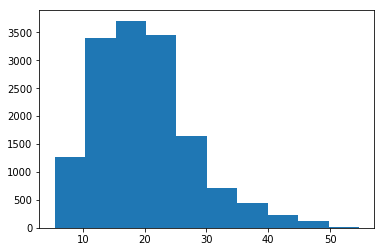

In [10]:
plt.hist(a_A)

In [ ]:
np.mean(a_A)/np.mean(b_A)**2

In [ ]:
plt.hist(A[100:i,3])

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(a_A,lags=len(a_A)-1)
plot_acf(b_A,lags=len(b_A)-1)
plt.show

In [ ]:
np.mean(a_A)